# ESMValTool Prov Template

The Earth System Model eValuation Tool (ESMValTool) is a community diagnostics and performance metrics tool for the evaluation of Earth System Models (ESMs) that allows for routine comparison of single or multiple models, either against predecessor versions or against observations(ESMValTool, http://esmvaltool.org). 
The tool is composed of a large collection of individual diagnostics, which are organized in a common framework with respect to configuration, pre-processing and data input as well as data output. The tool development is organized as a community effort on github (https://github.com/ESMValGroup/ESMValTool). 

The ESMValTool community started to work towards a generic provenance solution, including a first sketch of a PROV based representation
(https://github.com/ESMValGroup/ESMValTool/blob/version2_provenance/esmvaltool/scatch_provenance.py, https://github.com/ESMValGroup/ESMValTool/issues/240#issuecomment-399019254)

Based on this previous work in the following a PROV template representation for ESMValTool is given, which can be used for automatic expansion to generate PROV representations for specific ESMValTool runs.
Links to the EnvriPlus-PROV tools:
* online extension service https://envriplus-provenance.test.fedcloud.eu/ 
* github repo: https://github.com/EnvriPlus-PROV/EnvriProvTemplates

## Template definition
The template generation is done based on the python prov library in the following, including short comments to characterize the individual entities and relations.
The original Prov representation for ESMValtool results was based on mainly on a single namespace ('evt' in the following). This was extended to refer to well established vocabulary definitions (like "foaf", "dc"), yet this has to be refined and communicated back to the ESMValtool developers group...

In [1]:
import datetime as dt

# visualize the graph
from prov.dot import prov_to_dot
from prov.model import ProvDocument

# Create a new provenance document
d0 = ProvDocument()


# Declaring namespaces for various prefixes
ns_dict = {
    'prov':'http://www.w3.org/ns/prov#',
    'var':'http://openprovenance.org/var#',
    'vargen':'http://openprovenance.org/vargen#',
    'tmpl':'http://openprovenance.org/tmpl#',
    'foaf':'http://xmlns.com/foaf/0.1/',
    'ex': 'http://example.org/',
    'orcid':'http://orcid.org/',
    'dc':'http://purl.org/dc/elements/1.1/',
    'gen':'http://enes.org/provgen',

    #document.set_default_namespace('http://example.org/0/')
    'rdf':'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'rdfs':'http://www.w3.org/2000/01/rdf-schema#',
    'xsd':'http://www.w3.org/2001/XMLSchema#',
    'ex1': 'http://example.org/1/',
    'ex2': 'http://example.org/2/'
}
for key,val in ns_dict.items():
    d0.add_namespace(key,val)
    
d0.add_namespace('evt', 'http://www.esmvaltool.org/scheme')
d1 = d0.bundle('vargen:bundleid')

# Entities:
# - outfile entities represent diagnostic outputs (mainly figures)
#   commented variables are proposed extensions not foreseen in the original draft
#
outfile = d1.entity(
    'var:outfile', {
        'evt:caption': 'var:caption',
        'evt:variable': 'var:variable',
        'evt:plottype': 'var:plottype',
        'evt:domain': 'var:domain',
        'evt:theme': 'var:theme',
        'evt:realm': 'var:realm',
#       'dc:format': 'var:outfile_format', # mime type
#       'dc:subject': 'var:outfile_subject',
#       'dc:type':'var:outfile_type',
#       'dc:title':'var:outfile_title',
#       'dc:description','var:outfile_description'
    })

# - diagnostic entities represent individual diagnostics packages
diagnostic = d1.entity(
    'evt:diagnostic', {
        'evt:description': 'var:diag_description',
        'evt:references': 'var:references',
        'evt:statistics': 'var:statistics'
    })

# - recipe entities refer to data input characterizations based on so called namelists
recipe = d1.entity(
    'evt:recipe', {
        'evt:description': 'var:nml_description',
        'evt:project': 'var:project',
        'evt:references': 'var:nml_references'
    })


# - data_collection represent heterogeneous data collections, which are composed of indiviual datasets
#   (datasets are composed of a set of individual data files)
#   the instantiation of collections is done by a specific expansion function ('gen_data_collection')
#   which has to be defined in the context this template is evaluated in
#   (by now this structure of collections is hidden in the template, could be made explicit in the future, yet requires 
#    more generic and sophisticated approach for instantiation function matching)
collection = d1.entity('gen:data_collection',
                     {'prov:type': 'prov:Collection',
                      'gen:script':'gen_data_collection(provdoc,provcollection,ds_dict)'
                      })

# - preproc_files represent intermediate preprocessing results used in the diagnostics routines
preprocfile = d1.entity('evt:preproc_file')
software = d1.agent('evt:software', {
    'prov:type':'prov:SoftwareAgent',
    'evt:ESMValTool': 'var:ESMValTool',
    'evt:Python': 'var:Python',
    'evt:NCL': 'var:NCL',
#   'dcType:software': 'ESMValTool'
})

# - preprocessors and analytic routines use specific configuration settings 
#   represented in 'preproc_setting' as well as 'diag_setting' entities
preproc_set = d1.entity(
    'evt:preproc_setting', {   
        'evt:derivation': 'var:derivation',
        'evt:timesel': 'var:timesel',
        'evt:cmor': 'var:cmor_fixes',
        'evt:levelint': 'var:levelint',
        'evt:regridding': 'var:regridding',
        'evt:masking': 'var:masking',
        'evt:multimeanstat': 'var:multimeanstat'
    })

diag_set = d1.entity('evt:diag_setting')

# Agent:
# - Authors for namelists and diagnostics 
#   currently separated, can be joined to a common "author" agent ( if properties stay similiar, tbd.) 
author_nml = d1.agent('var:Author_nml',{
     'prov:type':'prov:Person','foaf:name':'var:name'
})

author_diag = d1.agent('var:Author_diag',{
     'prov:type':'prov:Person','foaf:name':'var:name'
})


# Activities
# - executions of diagnostic runs as well as preprocessing runs represent
#   activites
diagrun = d1.activity('evt:diagrun')
preprocrun = d1.activity('evt:preprocrun')


# Relations
# - output files are derived from input specifications
# - ouput files are generated by diagnostic runs
# - intermediate preproc files are generated by preprocessor runs
# - diagnostic runs use diagnostic software (with config seetings), preproc file
# - preproc runs use data collections, software (with config settings)
# - recipes as well as diagnostics are attributed to authors
d1.wasDerivedFrom(outfile, recipe)

d1.wasGeneratedBy(outfile, diagrun)
d1.wasGeneratedBy(preprocfile, preprocrun)

d1.used(diagrun, diagnostic)
d1.used(diagrun, preprocfile)
d1.used(diagrun, diag_set)
d1.wasAssociatedWith(diagrun, software)
d1.used(preprocrun, collection)
d1.wasAssociatedWith(preprocrun, software)
d1.used(preprocrun, preproc_set)

d1.wasAttributedTo(recipe, author_nml)
d1.wasAttributedTo(diagnostic, author_diag)

print(d0.get_provn())
d0.serialize('esmval-prov.xml', format='xml')
d0.serialize('esmval-prov.rdf',format='rdf')
dot = prov_to_dot(d0)
dot.write_png('esmval-prov.png')
#
# Or save to a PDF
dot.write_pdf('esmval-prov.pdf')

document
  prefix var <http://openprovenance.org/var#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  prefix dc <http://purl.org/dc/elements/1.1/>
  prefix gen <http://enes.org/provgen>
  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>
  prefix ex1 <http://example.org/1/>
  prefix ex2 <http://example.org/2/>
  prefix evt <http://www.esmvaltool.org/scheme>
  
  bundle vargen:bundleid
    prefix var <http://openprovenance.org/var#>
    prefix evt <http://www.esmvaltool.org/scheme>
    prefix gen <http://enes.org/provgen>
    
    entity(var:outfile, [evt:caption="var:caption", evt:variable="var:variable", evt:plottype="var:plottype", evt:domain="var:domain", evt:theme="var:theme", evt:realm="var:realm"])
    entity(evt:diagnostic, [evt:description="var:diag_desc

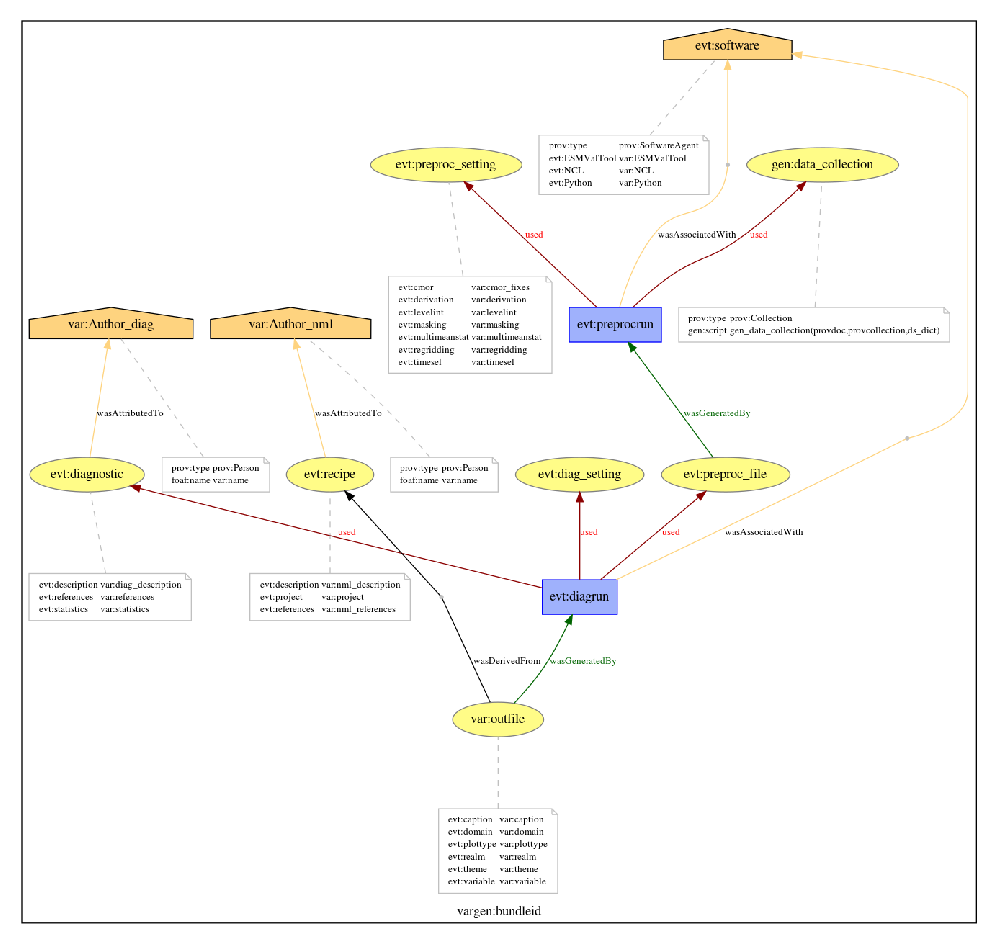

In [2]:
%matplotlib  inline
d0.plot()
from prov.dot import prov_to_dot
dot = prov_to_dot(d0)
dot.write_png('esmval-template.png')

## Example expansion of the template 

Using generic ENVRI+prov expansion implementation

In [4]:
from provtemplates import provconv

instance_dict = {}
entities ={"var:Author_nml": ["evt:Author_nml1","evt:Autor_nml2"], "var:Author_diag":["evt:Author_diag1","evt:Author_diag2"],
                 "var:outfile":"evt:outfile1",
                 "var:dataset":["evt:dataset1","evt:dataset2","evt:dataset3","evt:dataset4"],
                 "var:infile":["evt:infile1","evt:infile2","evt:infile3"],
                 "var:preproc_file":"evt:preproc_file1"
          }

var_outfile =  {
        'var:caption':'outfile_caption',
         'var:variable':'outfile_variable',
         'var:plottype':'plottype',
         'var:domain':'domain',
        'var:theme':'theme',
        'var:realm':'realm'
    }

var_diagnostic = {
       'var:diag_description':'diag_description',
       'var:references':'references',
       'var:statistics':'statistics'
    }

var_recipe = {
        'var:nml_description':'nml_description',
        'var:project':'project',
        'var:nml_references':'nml_references'
}

var_software = {
                 'var:ESMValTool':"v1.0.1",
                 'var:Python':"v3.0.1",
                 'var:NCL':"v1.0.1"
}
#var_infile = {'var:tracking_id:':"000.000.0000",'var:tracking_id:':"000.000.0001",'var:tracking_id:':"000.000.0002"}

var_preproc_setting = {
                 'var:derivation': 'Derivation',
                 'var:timesel': 'Timesel',
                 'var:cmor': 'CMOR_fixes',
                 'var:levelint': 'Level interpolation',
                 'var:regridding': 'Regridding',
                 'var:masking': 'Masking',
                 'var:multimeanstat': 'Multimean statistics',
                }

instance_dict.update(entities)
instance_dict.update(var_outfile)
instance_dict.update(var_diagnostic)
instance_dict.update(var_recipe)
instance_dict.update(var_software)
#instance_dict.update(var_infile)
instance_dict.update(var_preproc_setting)

new_inst = provconv.instantiate_template(d0,instance_dict)
new1 = list(new_inst.bundles)[0] # select the bundle (will be further expanded)
print(new_inst.get_provn())

[(<QualifiedName: evt:caption>, 'outfile_caption'), (<QualifiedName: evt:variable>, 'outfile_variable'), (<QualifiedName: evt:plottype>, 'plottype'), (<QualifiedName: evt:domain>, 'domain'), (<QualifiedName: evt:theme>, 'theme'), (<QualifiedName: evt:realm>, 'realm')]
<ProvBundle: vargen:bundleid>
evt:outfile1
entity(evt:outfile1; [evt:caption="outfile_caption", evt:variable="outfile_variable", evt:plottype="plottype", evt:domain="domain", evt:theme="theme", evt:realm="realm"])
[(<QualifiedName: evt:description>, 'diag_description'), (<QualifiedName: evt:references>, 'references'), (<QualifiedName: evt:statistics>, 'statistics')]
<ProvBundle: vargen:bundleid>
evt:diagnostic
entity(evt:diagnostic; [evt:description="diag_description", evt:references="references", evt:statistics="statistics"])
[(<QualifiedName: evt:description>, 'nml_description'), (<QualifiedName: evt:project>, 'project'), (<QualifiedName: evt:references>, 'nml_references')]
<ProvBundle: vargen:bundleid>
evt:recipe
entit

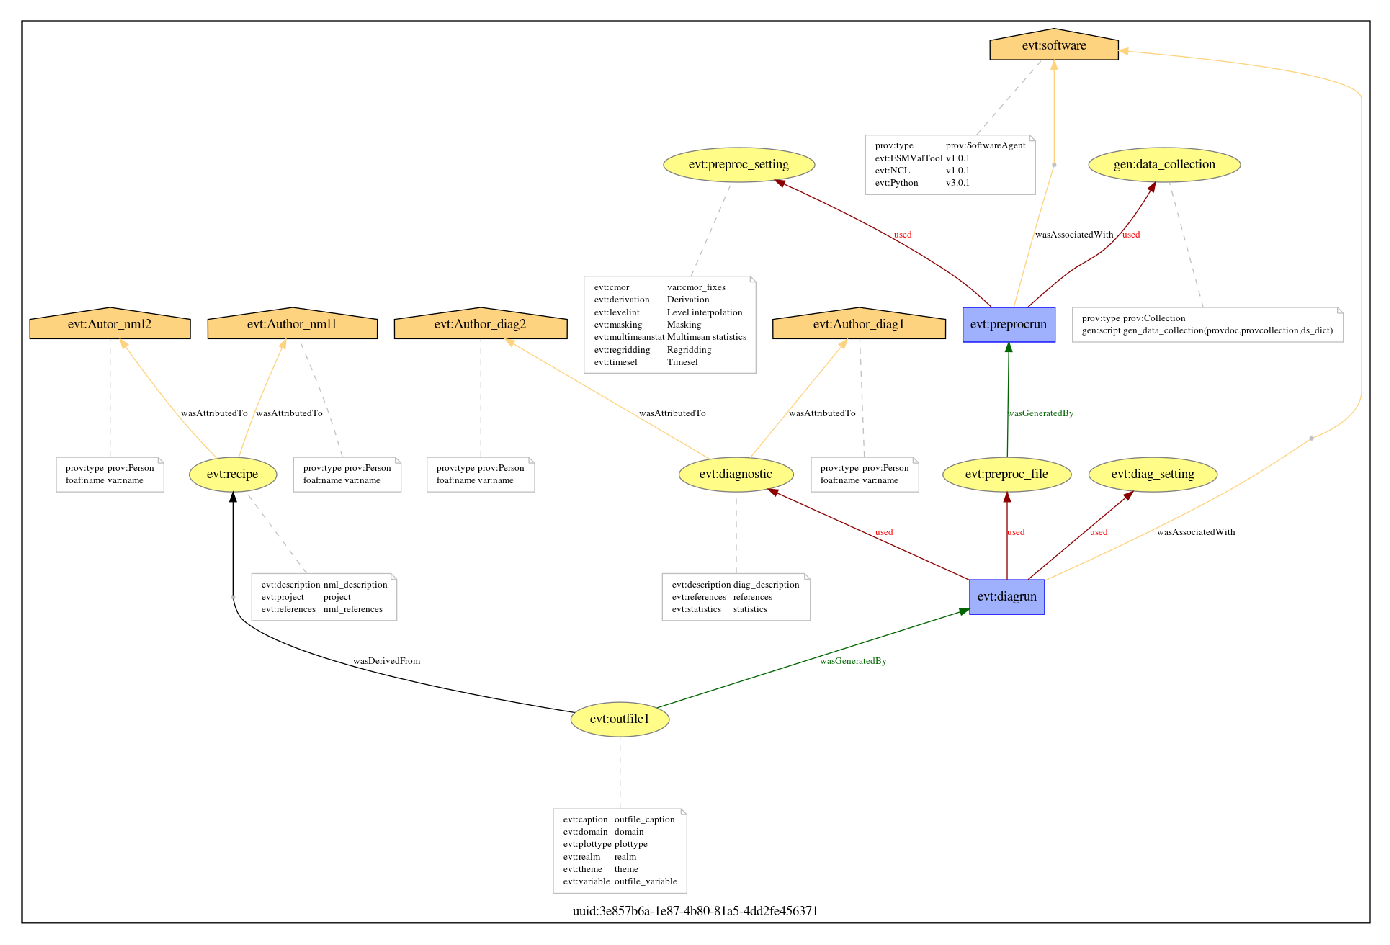

In [5]:
%matplotlib  inline
new_inst.plot()




## Additional expansion of data collection

- expansion function is declared explicitely first
  (will probably be part of community extension library for ENVRI+prov in the future)

In [7]:
def gen_data_collection(doc,collection,pars):
    
    id = 0
    for ds_id in pars['ds_ids']:
        ds_info = pars[ds_id]
        dataset =  doc.entity('evt:'+ds_id, 
           {'ex:source': ds_info['source'], 
            'ex:name':ds_id,
            'dc:identifier':ds_info['tracking_id']
        })
        
        for sfile in ds_info['files']:
            file_info = ds_info[sfile]
            file_ent = doc.entity('evt:'+sfile,
                   {'dc:identifier': file_info['tracking_id'],
                    'ex:name': sfile
                   })
            doc.used(dataset,file_ent)
        
        doc.hadMember(collection, dataset) 
    return doc
     

def get_expscript(collection):
    attrs = collection.attributes
    for (aname,avalue) in attrs: 
        print(aname.localpart)
        if aname.localpart == 'script':
           return avalue
    return 'no script'

def evaluate_expression(expression, doc, collection, pars):
    provdoc = doc
    provcollection = collection
    ds_dict = pars
    result = eval(expression)
    return result


### instantiation information 
mypars = {'ds_ids':['ds1','ds2','ds3'],
          'ds1':  { 
              'files':['ds1file1','ds1file2'],
              'source':'ESGF DKRZ',
              'tracking_id':'hdl.net:222/1111.1111.1111',
              'ds1file1': {'tracking_id':'hdl.net:111/000.000.0001'},
              'ds1file2': {'tracking_id':'hdl.net:111/000.000.0002'}
          },
          'ds2': {
              'files' : ['ds2file1'],
              'source':'ESGF DKRZ',
              'ds2file1':{'tracking_id':'hdl.net:111/000.000.0003'},
              'tracking_id':'hdl.net:222/444.444.444',
          },
          'ds3':{ 
              'files' : [],
               'source':'Obs DKRZ',
              'tracking_id':'hdl.net:222/000.000.666'
          }
          }    

    
script = get_expscript(collection)
print('---------> ',script)

result = evaluate_expression(script,new1,collection,mypars)
print(result.get_provn())

type
script
--------->  gen_data_collection(provdoc,provcollection,ds_dict)
bundle uuid:3e857b6a-1e87-4b80-81a5-4dd2fe456371
  prefix evt <http://www.esmvaltool.org/scheme>
  prefix gen <http://enes.org/provgen>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  
  entity(evt:outfile1, [evt:caption="outfile_caption", evt:variable="outfile_variable", evt:plottype="plottype", evt:domain="domain", evt:theme="theme", evt:realm="realm"])
  entity(evt:diagnostic, [evt:description="diag_description", evt:references="references", evt:statistics="statistics"])
  entity(evt:recipe, [evt:description="nml_description", evt:project="project", evt:references="nml_references"])
  entity(gen:data_collection, [prov:type="prov:Collection", gen:script="gen_data_collection(provdoc,provcollection,ds_dict)"])
  entity(evt:preproc_file)
  agent(evt:software, [prov:type="prov:SoftwareAgent", evt:ESMValTool="v1.0.1", evt:Python="v3.0.1", evt:NCL="v1.0.1"])
  entity(evt:preproc_setting, [evt:derivation="Derivation", 

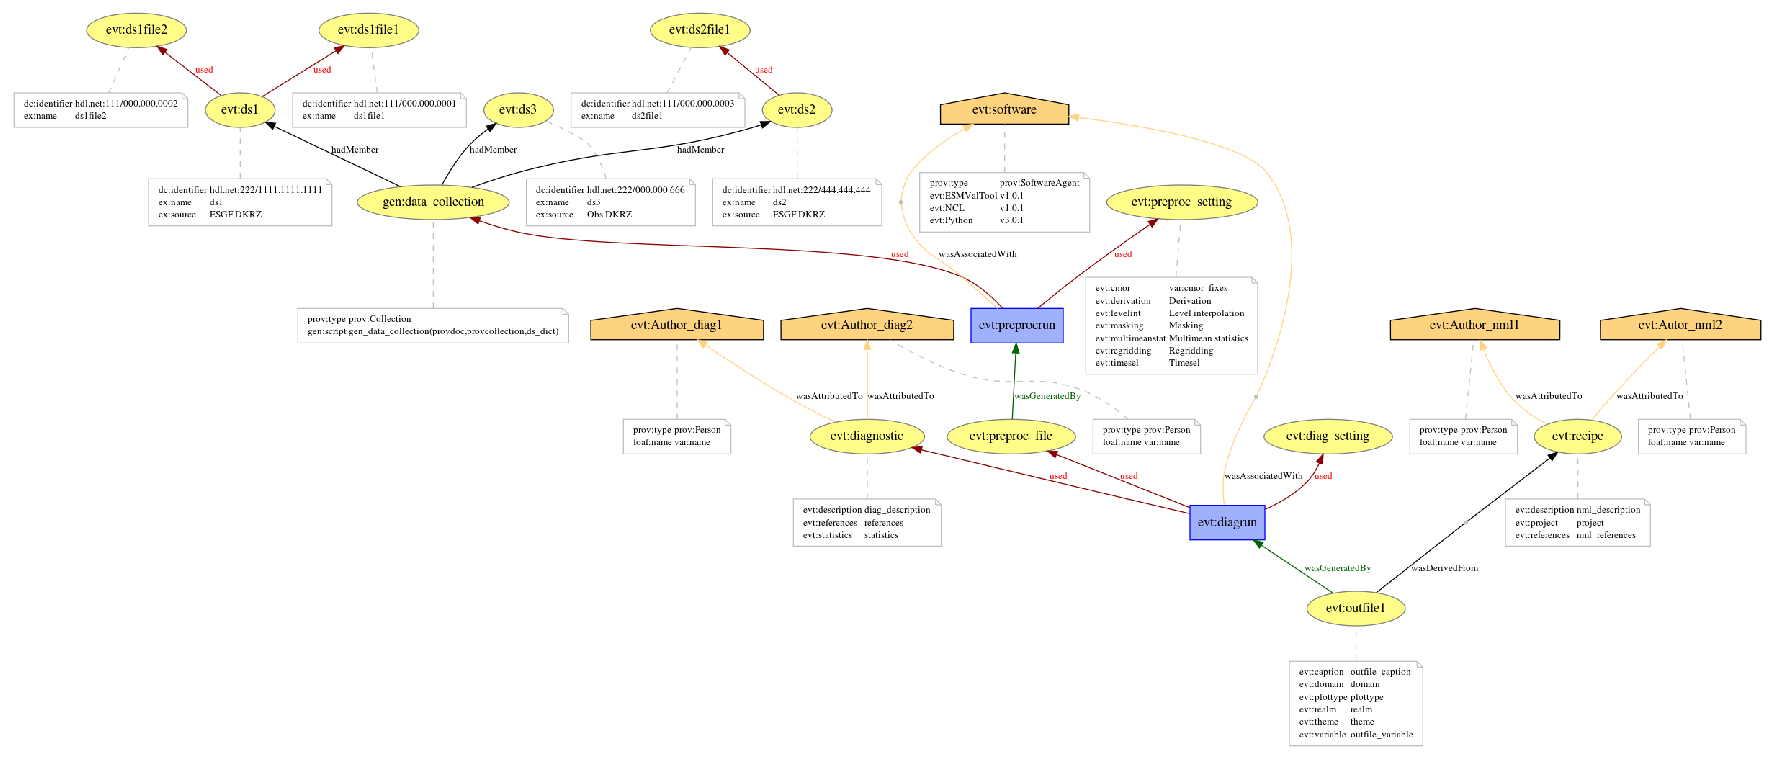

In [8]:
%matplotlib  inline
result.plot()

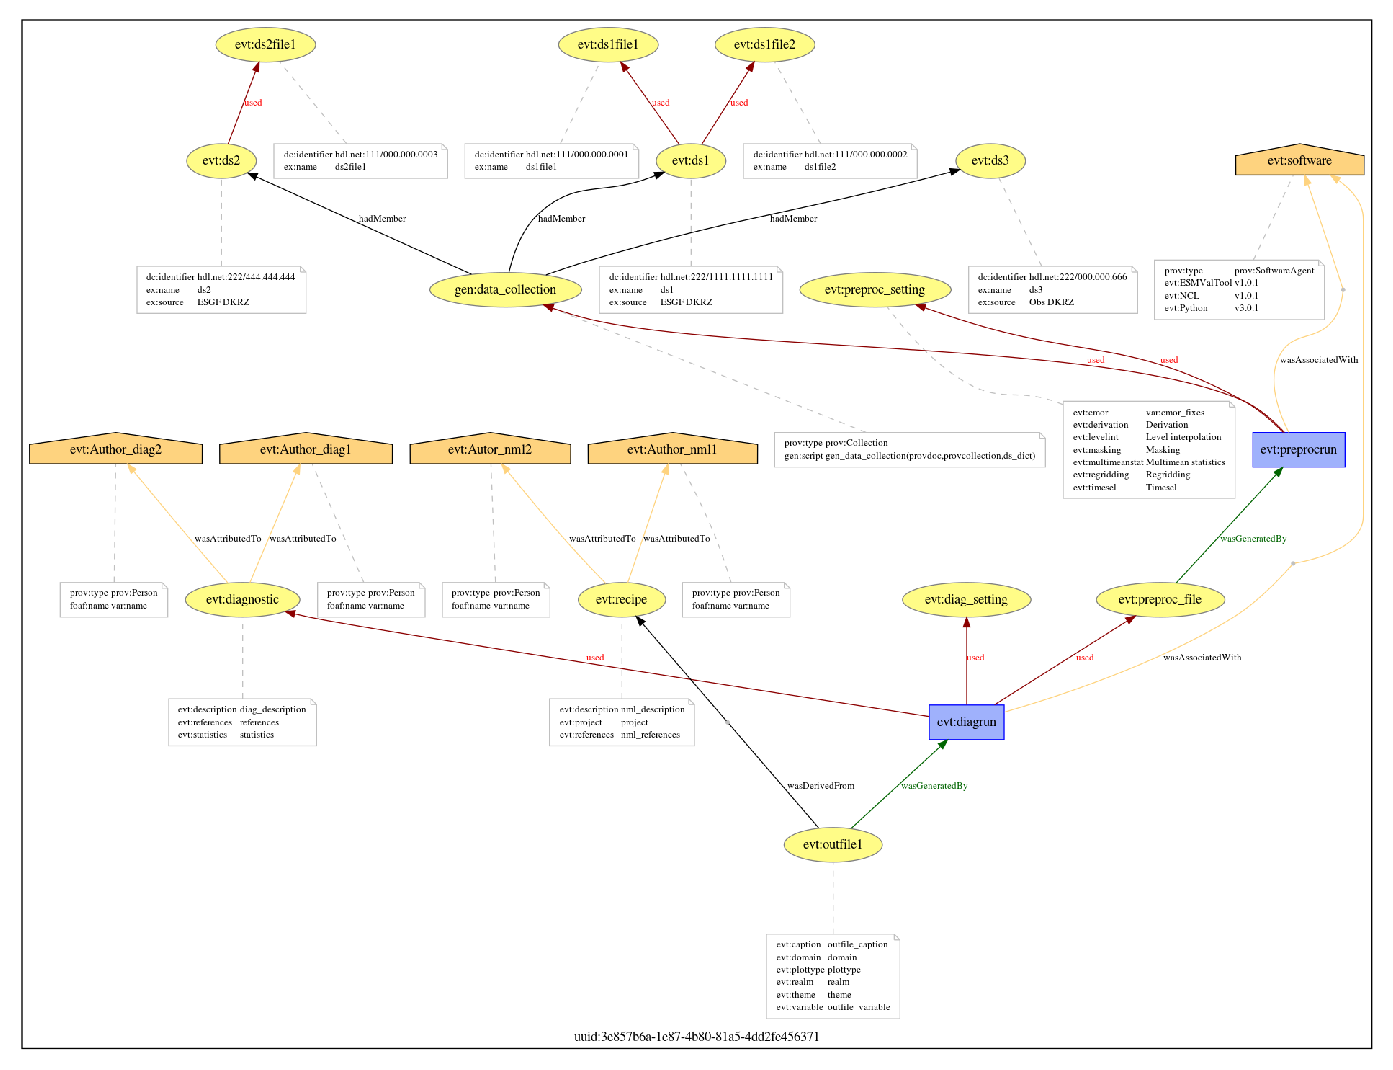

In [9]:
%matplotlib  inline
new_inst.plot()

# ------------------Old-------------------------------------------

In [ ]:
from prov.dot import prov_to_dot
from prov.model import ProvDocument

def gen_data_collection(doc,collection,pars):
    
    for ds_id in pars['ds_ids']:
        ds_info = pars[ds_id]
        dataset =  doc.entity('evt:'+ds_id, pars[ds_id]['attributes'] )
        
        for sfile in ds_info['files']:
            file_info = pars[sfile]
            file_ent = doc.entity('evt:'+sfile, pars[sfile]['attributes'] )
            dataset.hadMember(file_ent)
        
        doc.hadMember(collection, dataset)
        #collection.hadMember(dataset) 
    return doc
   
mypars = {'ds_ids':['ds1','ds2','ds3'],
          'ds1':  { 
              'files':['ds1file1','ds1file2'],
              'attributes': {
                  'var:source': 'evt:ESGF', 
                  'var:name':'evt:ds1',
                  'var:trackingid':'evt:hdl.net222/1111.1111.1111'
              }
           },
           'ds1file1': {
               'attributes':{
                   'var:trackingid': 'dc:111/000.000.0001',
                   'var:name': 'evtds1file1'
                   }
           },               
           'ds1file2': {
                  'attributes':{
                   'var:trackingid': 'hdl.net:111/000.000.0002',
                   'var:name': 'ds1file2'
                   }
            },
           'ds2': {
              'files' : ['ds2file1'],
              'attributes': {
                  'var:source': 'ESGF', 
                  'var:name':'ds2',
                  'var:identifier':'hdl.net:222/1111.2222.2222'
               }     
            },
            'ds2file1': {
                  'attributes':{
                   'var:trackingid': 'dkrz.de/xxx.xxx',
                   'var:name': 'evt:ds2file1'
                   }
            },
           'ds3':{ 
              'files' : [],
              'attributes': {
                  'var:source': 'ESGF DKRZ', 
                  'var:name':'ds3',
                  'var:identifier':'hdl.net:222/1111.333.3333'
               }     
            }
}      

def get_expscript(mycollection):
    attrs = mycollection.attributes
    for (aname,avalue) in attrs: 
        print(aname.localpart)
        if aname.localpart == 'script':
           return avalue
    return 'no script'

def evaluate_expression(expression,doc, collection, pars):
    provdoc = doc
    provcollection = collection
    ds_dict = pars
    result = eval(expression)
    return result

    
script = get_expscript(collection)
print('---------> ',script)
result = evaluate_expression(script,new, collection,mypars)
print(result.get_provn())

In [ ]:
%matplotlib  inline
result.plot()

In [ ]:
from pathlib import Path,PureWindowsPath
from provtemplates import provconv
import prov

inputdir = Path('/Users/snkin/Repos/enes_graph_use_case/prov_templates/test')
inputfile = inputdir / 'binding1.ttl'

template = inputdir / 'template1.xml'
print(inputfile)
binding = prov.read(inputfile)

template1 = prov.read(template)
b_dict = provconv.read_binding(binding)

new = provconv.instantiate_template(template1,b_dict)
print(template1.get_provn())
print(new.get_provn())

In [ ]:
%matplotlib  inline
result.plot()

In [ ]:
ns = prov.identifier.Namespace('ll','http://test.dkrz.de/ll')
newid = prov.identifier.QualifiedName(ns,'tst')


In [ ]:
%matplotlib  inline
d1.plot()

In [ ]:
%matplotlib  inline
d1.plot()

In [ ]:
%matplotlib  inline
new.plot()

In [ ]:
%matplotlib  inline
d1.plot()